**Punto 4:**

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
import re
from collections import defaultdict

# 4.1) Limpiado de datos
def clean_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        s = file.read()

    # Limpiar el texto
    s = s.replace("\r\n", "\n").replace("\n\n", "#").replace("\n", " ").replace("#", "\n\n")
    s = re.sub(r'[^a-zA-Z0-9\s.,!?;\'\"-]', '', s)  # Limpiar caracteres especiales
    s = re.sub(r'\s+', ' ', s)  # Eliminar espacios repetidos
    s = s.lower()  # Convertir a minúsculas

    return s.strip()

# 4.2) Entrenamiento y predicción
def build_ngram_frequencies(text, n):
    frequencies = defaultdict(lambda: defaultdict(int))
    for i in range(len(text) - n):
        ngram = text[i:i+n]
        next_char = text[i+n]
        frequencies[ngram][next_char] += 1

    return {ngram: dict(next_chars) for ngram, next_chars in frequencies.items()}

def combine_frequencies(freq_lists):
    combined = defaultdict(lambda: defaultdict(int))
    for freq in freq_lists:
        for ngram, next_chars in freq.items():
            for next_char, count in next_chars.items():
                combined[ngram][next_char] += count
    return {ngram: dict(next_chars) for ngram, next_chars in combined.items()}

def process_chunk(chunk, n):
    return build_ngram_frequencies("".join(chunk), n)

def train_and_predict(text, n):
    if len(text) < n + 1:
        raise ValueError(f"El texto es demasiado corto para n={n}.")

    chunks = np.array_split(list(text), 4)
    with multiprocessing.Pool() as pool:
        freq_results = pool.starmap(process_chunk, [(chunk, n) for chunk in chunks])
    ngram_frequencies = combine_frequencies(freq_results)

    # Normalizar
    for ngram, next_chars in ngram_frequencies.items():
        total = sum(next_chars.values())
        for next_char in next_chars:
            next_chars[next_char] /= total

    # Seleccionar un n-grama inicial
    initial_ngram = np.random.choice(list(ngram_frequencies.keys()))
    return ngram_frequencies, initial_ngram

def generate_text(ngram_frequencies, initial_ngram, m=1500):
    generated = initial_ngram
    current_ngram = initial_ngram

    for _ in range(m):
        next_chars = ngram_frequencies.get(current_ngram, {})
        if not next_chars:
            break
        next_char = np.random.choice(list(next_chars.keys()), p=list(next_chars.values()))
        generated += next_char
        current_ngram = generated[-len(initial_ngram):]

    return generated

# Cargar y limpiar el texto
file_path = 'TheGreatGatsby.txt'
cleaned_text = clean_text(file_path)

if not cleaned_text:
    raise ValueError("El texto limpio está vacío. Verifica el archivo de entrada.")

# 4.3) Análisis
with open('words_alpha.txt', 'r') as f:
    valid_words = set(word.strip() for word in f.readlines())

results = {}
for n in range(1, 8):
    ngram_frequencies, initial_ngram = train_and_predict(cleaned_text, n)
    generated_text = generate_text(ngram_frequencies, initial_ngram, m=1500)

    # Contar palabras válidas
    words = generated_text.split()
    valid_count = sum(1 for word in words if word in valid_words)
    valid_percentage = (valid_count / len(words)) * 100 if words else 0

    results[n] = valid_percentage

for n, percentage in results.items():
    print(f"n={n}: Porcentaje de palabras válidas = {percentage:.2f}%")

print(f"Texto limpio (muestra): {cleaned_text[:200]}")
print(f"Número de palabras válidas cargadas: {len(valid_words)}")



n=1: Porcentaje de palabras válidas = 43.82%
n=2: Porcentaje de palabras válidas = 51.14%
n=3: Porcentaje de palabras válidas = 63.20%
n=4: Porcentaje de palabras válidas = 73.48%
n=5: Porcentaje de palabras válidas = 86.67%
n=6: Porcentaje de palabras válidas = 84.93%
n=7: Porcentaje de palabras válidas = 86.69%
Texto limpio (muestra): the project gutenberg ebook of the great gatsby this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoeve
Número de palabras válidas cargadas: 370104


**¿Cuál es el mínimo 𝑛 que usted considera necesario para producir algo más o menos legible?**

En este caso, desde el n = 1 hubo un porcentaje bastante alto, casi del 50% de coincidencias, sin embargo para ir a lo seguro apostaria a que a partir del n = 5 podia obtenerse algo legible y coherente en su mayoria. Si bien, nisiquiera en un n = 7 se obtuvo algo mayor al 90%, teniendo en cuenta que esta es una version inferior y simplificada de un transformer, los resultados fueron bastante efectivos.

**¿Depende esto del libro usado para entrenar el modelo? ¿del género del libro (novela, poesía, ensayo, etc)? ¿del lenguaje del libro?**

Creeria que si, pero en menor medida, al principio teniamos la idea de utilizar un libro mas viejo como Romeo y Julieta de Shakespear, sin embargo viendo por encima el libro nos percatamos que el ingles que este empleaba era uno correpsondiente a la epoca en la que se escribio el cual no es acorde al actual, esto tambien se puede evidenciar en el idioma español con libro como El Quijote de la Mancha, el cual tiene un lenguaje muy anticuado comparado con el actual. En cuanto a otros aspectos como el genero de libro no creo que sea algo muy relevante, diria que tal vez, por ejemplo, en libros de horror palabras como "blood" o "ghost" son mas comunes que en un libro de drama romantico, no obstante no creo que esto restrinja mucho modelo de lenguaje.



**Responda lo que se le ocurra: ¿qué pasos habría que seguir para que este modelo pudiera mantener una conversación, o producir frases gramaticalmente correctas?**

Como el único modelo que tengo de referencia son ChatGPT y Gemini diría que hacer lo que estos hacen, es decir, tener una base de datos absurdamente grande, en el caso de ChatGPT tengo entendido que él puede acceder a cualquier información que este en el internet de cierta fecha hasta el 2021, lo cual es algo infinitamente muchos más grande comparado con un archivo txt de un libro y una word bank de palabras en inglés. Por otra parte, recordando a otros modelos o bots de chat se me ocurre algo como Simsimi o Akinator los cuales depende estrechamente de tener interacción con muchos usuarios. En conclusión, para que el modelo pudiese mantener una conversación o producir frases gramaticalmente correctas este debería tener una mayor base de datos y tener la capacidad de aprender de los usuarios a partir de la interacción con estos mismo, por ende, sería útil también implementar algoritmos de machine learning.




**Punto 5**

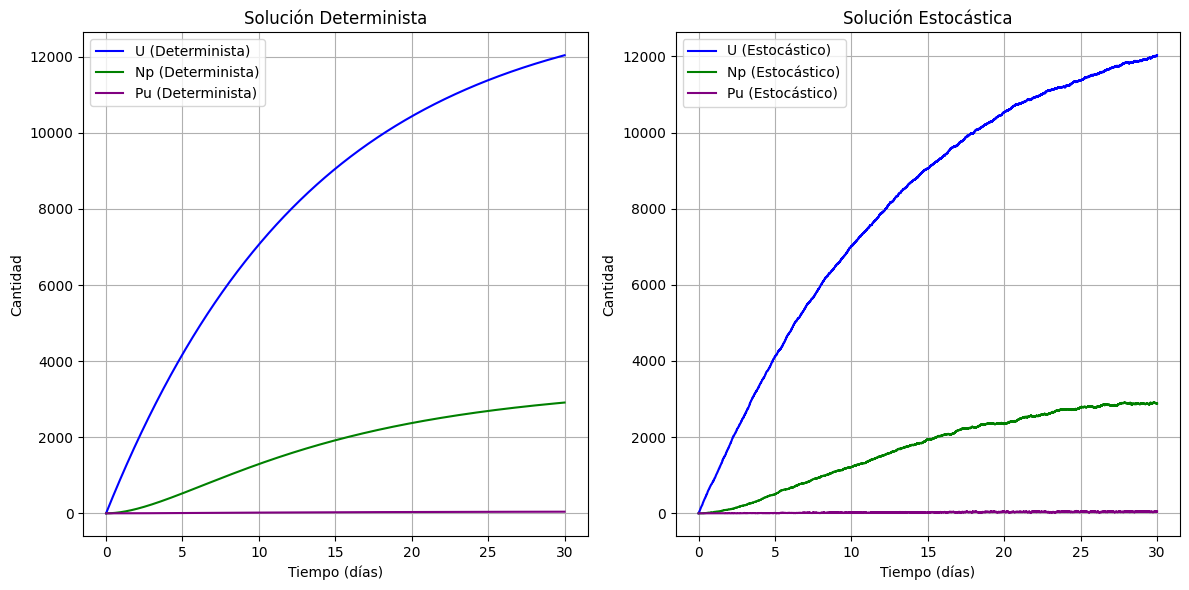

Probabilidad de que Pu llegue a ser >= 80: 0.0000


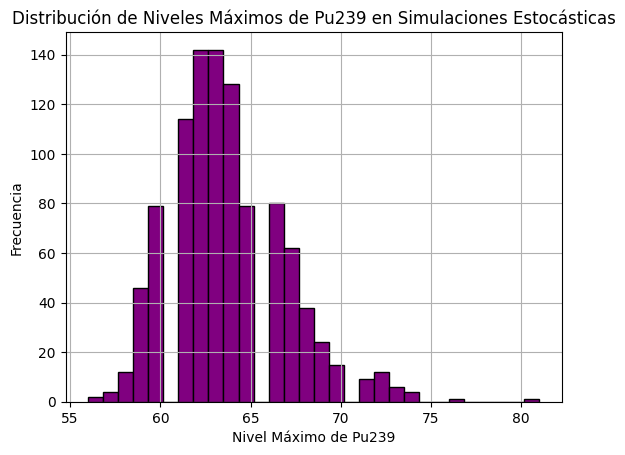

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Constantes
A = 1000  # Tasa de producción de U239
B = 20    # Tasa de extracción de Pu239
vida_media_U = 23.4 / 60  # vida media de U239 en horas -> convertida a días
vida_media_Np = 2.36      # vida media de Np239 en días

# Constantes de decaimiento
lambda_U = np.log(2) / (vida_media_U * 24)
lambda_Np = np.log(2) / vida_media_Np

# Sistema determinista
def sistema_determinista(Y, t):
    U, Np, Pu = Y
    dU_dt = A - lambda_U * U
    dNp_dt = lambda_U * U - lambda_Np * Np
    dPu_dt = lambda_Np * Np - B * Pu
    return [dU_dt, dNp_dt, dPu_dt]

# Simulación estocástica usando el algoritmo de Gillespie
def simulacion_gillespie(t_max=30):
    # Condiciones iniciales
    U, Np, Pu = 0, 0, 0
    tiempo = 0
    max_Pu = 0
    historial_tiempos = []
    historial_U = []
    historial_Np = []
    historial_Pu = []

    while tiempo < t_max:
        # Calcular tasas
        tasas = [A, lambda_U * U, lambda_Np * Np, B * Pu]
        tasa_total = sum(tasas)

        # Si la tasa total es cero, terminar la simulación
        if tasa_total == 0:
            break

        # Tiempo hasta la próxima reacción
        tau = random.expovariate(tasa_total)
        tiempo += tau

        # Elegir la próxima reacción basado en probabilidades
        reaccion = random.choices(range(len(tasas)), weights=tasas)[0]

        if reaccion == 0:
            U += 1
        elif reaccion == 1:
            if U > 0:
                U -= 1
                Np += 1
        elif reaccion == 2:
            if Np > 0:
                Np -= 1
                Pu += 1
        elif reaccion == 3:
            if Pu > 0:
                Pu -= 1

        # Guardar el estado
        historial_tiempos.append(tiempo)
        historial_U.append(U)
        historial_Np.append(Np)
        historial_Pu.append(Pu)

        # Seguir el máximo de Pu
        max_Pu = max(max_Pu, Pu)

    return historial_tiempos, historial_U, historial_Np, historial_Pu, max_Pu

# Simulación determinista (5.2a)
tiempo = np.linspace(0, 30, 1000)
condiciones_iniciales = [0, 0, 0]
solucion_determinista = odeint(sistema_determinista, condiciones_iniciales, tiempo)
U_determinista, Np_determinista, Pu_determinista = solucion_determinista.T

# Simulación estocástica (5.2a)
historial_tiempos, historial_U, historial_Np, historial_Pu, max_Pu = simulacion_gillespie()

# Graficar las soluciones
plt.figure(figsize=(12, 6))

# Gráfica para la solución determinista
plt.subplot(1, 2, 1)
plt.plot(tiempo, U_determinista, label='U (Determinista)', color='blue')
plt.plot(tiempo, Np_determinista, label='Np (Determinista)', color='green')
plt.plot(tiempo, Pu_determinista, label='Pu (Determinista)', color='purple')
plt.xlabel('Tiempo (días)')
plt.ylabel('Cantidad')
plt.title('Solución Determinista')
plt.legend()
plt.grid(True)

# Gráfica para la solución estocástica
plt.subplot(1, 2, 2)
plt.step(historial_tiempos, historial_U, label='U (Estocástico)', where='post', color='blue')
plt.step(historial_tiempos, historial_Np, label='Np (Estocástico)', where='post', color='green')
plt.step(historial_tiempos, historial_Pu, label='Pu (Estocástico)', where='post', color='purple')
plt.xlabel('Tiempo (días)')
plt.ylabel('Cantidad')
plt.title('Solución Estocástica')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 5.2b) Realizar múltiples simulaciones para determinar la probabilidad de que Pu >= 80
def realizar_simulaciones_multiples(n_simulaciones=1000, t_max=30, umbral=80):
    cuenta_excedido = 0
    for _ in range(n_simulaciones):
        _, _, _, _, max_Pu = simulacion_gillespie(t_max)
        if max_Pu >= umbral:
            cuenta_excedido += 1

    probabilidad = cuenta_excedido / n_simulaciones
    return probabilidad

# Ejecutar simulaciones para 5.2b
probabilidad_exceder_80 = realizar_simulaciones_multiples(n_simulaciones=1000)
print(f"Probabilidad de que Pu llegue a ser >= 80: {probabilidad_exceder_80:.4f}")

# Gráfica del histograma de valores máximos de Pu en múltiples simulaciones
valores_max_pu = [simulacion_gillespie()[4] for _ in range(1000)]
plt.hist(valores_max_pu, bins=30, color='purple', edgecolor='black')
plt.title('Distribución de Niveles Máximos de Pu239 en Simulaciones Estocásticas')
plt.xlabel('Nivel Máximo de Pu239')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

#La simulación tarda 10-15 mins con 5 gb de ram dedicadas al proceso, eso solo en el caso del 5.2b, los demás son más breves.

**Bono**

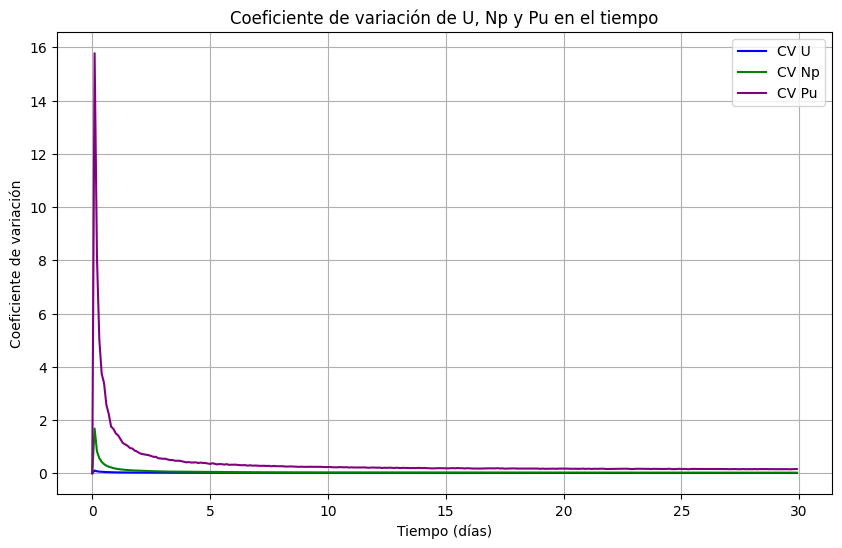

In [ ]:
# 5.2 Extra: Calcular el coeficiente de variación y graficar
def calcular_coeficiente_variacion(n_simulaciones=1000, t_max=30, dt=0.1):
    # Tiempo discretizado
    tiempos = np.arange(0, t_max, dt)
    num_puntos = len(tiempos)

    # Matrices para almacenar resultados de múltiples simulaciones
    resultados_U = np.zeros((n_simulaciones, num_puntos))
    resultados_Np = np.zeros((n_simulaciones, num_puntos))
    resultados_Pu = np.zeros((n_simulaciones, num_puntos))

    for sim in range(n_simulaciones):
        historial_tiempos, historial_U, historial_Np, historial_Pu, _ = simulacion_gillespie(t_max)

        # Interpolación de los resultados de la simulación para que coincidan con los tiempos discretizados
        resultados_U[sim, :] = np.interp(tiempos, historial_tiempos, historial_U, left=0, right=0)
        resultados_Np[sim, :] = np.interp(tiempos, historial_tiempos, historial_Np, left=0, right=0)
        resultados_Pu[sim, :] = np.interp(tiempos, historial_tiempos, historial_Pu, left=0, right=0)

    # Calcular media y desviación estándar para cada variable
    media_U = np.mean(resultados_U, axis=0)
    media_Np = np.mean(resultados_Np, axis=0)
    media_Pu = np.mean(resultados_Pu, axis=0)

    std_U = np.std(resultados_U, axis=0)
    std_Np = np.std(resultados_Np, axis=0)
    std_Pu = np.std(resultados_Pu, axis=0)

    # Calcular coeficiente de variación, evitando divisiones por cero
    cv_U = np.divide(std_U, media_U, out=np.zeros_like(std_U), where=media_U != 0)
    cv_Np = np.divide(std_Np, media_Np, out=np.zeros_like(std_Np), where=media_Np != 0)
    cv_Pu = np.divide(std_Pu, media_Pu, out=np.zeros_like(std_Pu), where=media_Pu != 0)

    # Graficar coeficiente de variación
    plt.figure(figsize=(10, 6))
    plt.plot(tiempos, cv_U, label='CV U', color='blue')
    plt.plot(tiempos, cv_Np, label='CV Np', color='green')
    plt.plot(tiempos, cv_Pu, label='CV Pu', color='purple')

    plt.xlabel('Tiempo (días)')
    plt.ylabel('Coeficiente de variación')
    plt.title('Coeficiente de variación de U, Np y Pu en el tiempo')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejecutar el cálculo del coeficiente de variación
calcular_coeficiente_variacion(n_simulaciones=1000, t_max=30, dt=0.1)
